In [2]:
import os
import json
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from keras.utils import to_categorical

import matplotlib.pyplot as plt

2024-07-14 05:33:26.204541: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


---

In [3]:
DATASET_PATH = os.path.join("..", "..", "data", "star_classification.csv")

In [4]:
df = pd.read_csv(DATASET_PATH)
df.head()

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
0,1.237661e+18,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,3606,301,2,79,6.543777e+18,GALAXY,0.634794,5812,56354,171
1,1.237665e+18,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,4518,301,5,119,1.176014e+19,GALAXY,0.779136,10445,58158,427
2,1.237661e+18,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,3606,301,2,120,5.152200e+18,GALAXY,0.644195,4576,55592,299
3,1.237663e+18,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,4192,301,3,214,1.030107e+19,GALAXY,0.932346,9149,58039,775
4,1.237680e+18,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,8102,301,3,137,6.891865e+18,GALAXY,0.116123,6121,56187,842


In [5]:
X = df.drop(columns=["class"])
scaler = StandardScaler()
X_normalized = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
X_normalized = X_normalized.astype(float)
X = X_normalized.to_numpy()

Y = df["class"]
Y = np.array(LabelEncoder().fit_transform(y=Y.values))
Y = np.array(OneHotEncoder().fit_transform(Y.reshape(-1, 1)).toarray()).astype(float)

In [6]:
train_X, test_X, train_Y, test_Y = train_test_split(X, Y, test_size=0.2, random_state=42)

train_X = np.array(train_X)#[:50000])
train_Y = np.array(train_Y)#[:50000])
test_X = np.array(test_X)
test_Y = np.array(test_Y)

## From Scratch
---

In [7]:
print(train_X.shape, train_Y.shape)

(80000, 17) (80000, 3)


In [8]:
import basic_model_sample
from basic_model_sample import DenseLayer, Sequential, SGD
from basic_conversions import matrix_to_wfloat, matrix_as_felt_string, vector_as_felt_string

In [13]:
layers = [
    DenseLayer(input_shape=train_X.shape[1], output_shape=5, activation="ReLU"), 
    DenseLayer(output_shape=5, activation="ReLU"), 
    DenseLayer(output_shape=train_Y.shape[1], activation="ReLU"), 
]

model = Sequential(layers, SGD(learning_rate=0.01))
model.build()
print("num params: ", model.num_params())

# print(f"Num params: {model.num_params()}")

model.train(train_X, train_Y, epochs=30, batch_size=1000, verbose=True)

predictions = model.forward(test_X)
print(f"prediction \n{predictions}")
loss = model.mse_loss(predictions, test_Y)
print(f"Final loss on test set: {loss}")

num params:  138
Epoch 1, Loss: 0.21728872800671967
Epoch 11, Loss: 0.18792234143237074
Epoch 21, Loss: 0.18792187249518277
prediction 
[[0.59497902 0.1894874  0.21552216]
 [0.59497414 0.18948962 0.21554349]
 [0.59497802 0.18948706 0.21552671]
 ...
 [0.59497235 0.18948026 0.21555396]
 [0.59497665 0.18948769 0.21553269]
 [0.59497485 0.18949163 0.21553979]]
Final loss on test set: 0.18838545356151995


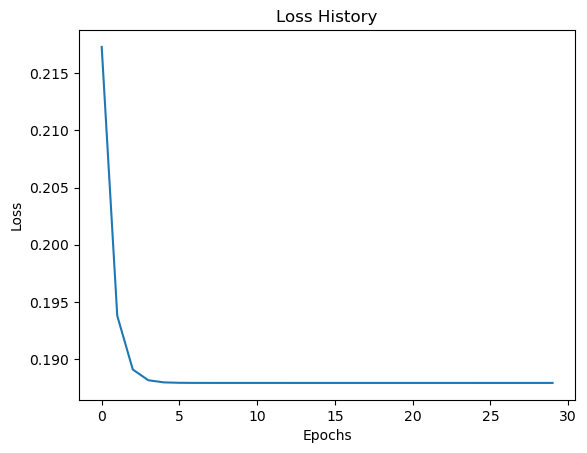

In [14]:
plt.plot(model.loss_history)
plt.title('Loss History')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

### Save

In [15]:
with open('model_weights.save', '+w') as f: 
    f.write(model.serialize())

# Keras check
---

In [120]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.losses import MeanSquaredError, CategoricalCrossentropy

model = Sequential([
    Dense(10, input_dim=train_X.shape[1], activation='relu'),
    Dense(10, activation='relu'),
    Dense(train_Y.shape[1], activation='relu')
])

model.compile(optimizer=SGD(learning_rate=0.01), loss=MeanSquaredError())

model.build(input_shape=(None, train_X.shape[1]))
model.summary()

history = model.fit(train_X, train_Y, epochs=20, batch_size=1000, verbose=1)

predictions = model.predict(test_X)
print(f"prediction \n{predictions}")

loss = model.evaluate(test_X, test_Y, verbose=0)
print(f"Final loss on test set: {loss}")

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 10)                180       
                                                                 
 dense_10 (Dense)            (None, 10)                110       


                                                                 
 dense_11 (Dense)            (None, 3)                 33        
                                                                 
Total params: 323
Trainable params: 323
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
80/80 [==============================] - 1s 8ms/step - loss: 0.3027
Epoch 2/20
80/80 [==============================] - 1s 13ms/step - loss: 0.2422
Epoch 3/20
80/80 [==============================] - 1s 9ms/step - loss: 0.2139
Epoch 4/20
80/80 [==============================] - 1s 9ms/step - loss: 0.2054
Epoch 5/20
80/80 [==============================] - 1s 9ms/step - loss: 0.2004
Epoch 6/20
80/80 [==============================] - 1s 12ms/step - loss: 0.1966
Epoch 7/20
80/80 [==============================] - 1s 7ms/step - loss: 0.1934
Epoch 8/20
80/80 [==============================] - 1s 7ms/step - loss: 0.1906
Epoch 9/20
80/80 [====================

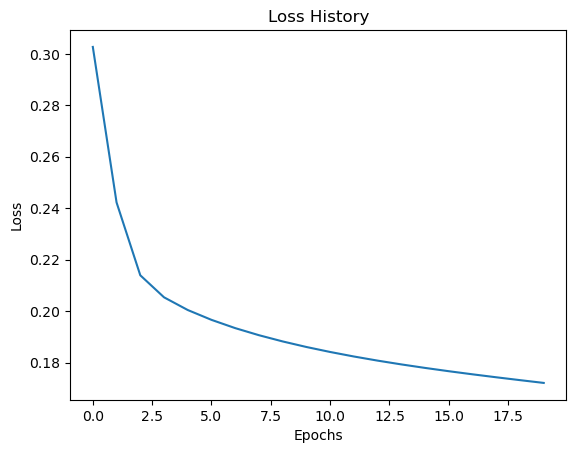

In [124]:
plt.plot(history.history['loss'])
plt.title('Loss History')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()